# Data Exploration

This notebook explores the Reddit data collected for our cross-lingual stance detection project on climate change discussions, including preliminary stance analysis.

In [61]:
# Configuration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import glob
import datetime
from tqdm import tqdm

# Set plotting style and configurations
sns.set_theme(style="whitegrid")  # Use seaborn's default style
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Constants
RANDOM_STATE = 42
FIGURE_SIZE = (12, 6)

In [62]:
# Load the data
latest_file = max(glob.glob('../data/raw/*.csv'), key=os.path.getctime)
data = pd.read_csv(latest_file)
print(f"Loaded {len(data)} posts")
data.head()

Loaded 8081 posts


,id,title,body,score,num_comments,created_utc,language,subreddit,collected_at,title_length,body_length,language_verified,verification_status,total_length
0,wu9zny,The r/climatechange Verified User Flair Program,r/climatechange is a community centered around...,41,20,2022-08-21 16:53:23,en,climatechange,2024-11-06 23:55:16.346632,47,3164,True,verified,3212
1,1glbafl,I’m incredibly sad for our environment today.,Trump has all but signed a death warrant for o...,717,196,2024-11-06 17:38:25,en,climatechange,2024-11-06 23:55:16.732102,46,527,True,verified,573
2,1glc2te,I’m sad. We really do live in a post-truth wor...,NaN,315,51,2024-11-06 18:13:11,en,climatechange,2024-11-06 23:55:16.735062,109,0,True,verified,108
3,1gl6msi,The US is about to make a sharp turn on climat...,NaN,160,27,2024-11-06 14:21:42,en,climatechange,2024-11-06 23:55:16.737426,54,0,True,verified,54
4,1gl7j9u,The US just abdicated from any role in climate...,Climate engineering is now the only chance hum...,123,22,2024-11-06 14:59:18,en,climatechange,2024-11-06 23:55:16.739338,151,70,True,verified,221


## 1. Basic Statistics

In [63]:
print(data.describe())
print("\nData distribution by language:")
print(data['language'].value_counts())

          score  num_comments  title_length  body_length  total_length
count  8081.000      8081.000      8081.000     8081.000      8081.000
mean     45.543        14.592        88.893      189.708       278.744
std     208.220        51.032        59.066      660.686       657.652
min       0.000         0.000         1.000        0.000         1.000
25%       2.000         0.000        53.000        0.000        65.000
50%      10.000         2.000        74.000        0.000        95.000
75%      37.000        11.000       103.000        0.000       229.000
max   10522.000      2135.000       300.000    17286.000     17330.000

Data distribution by language:
language
en    3972
de    1993
it     998
fr     988
es     130
Name: count, dtype: int64


## 2. Time Series Analysis

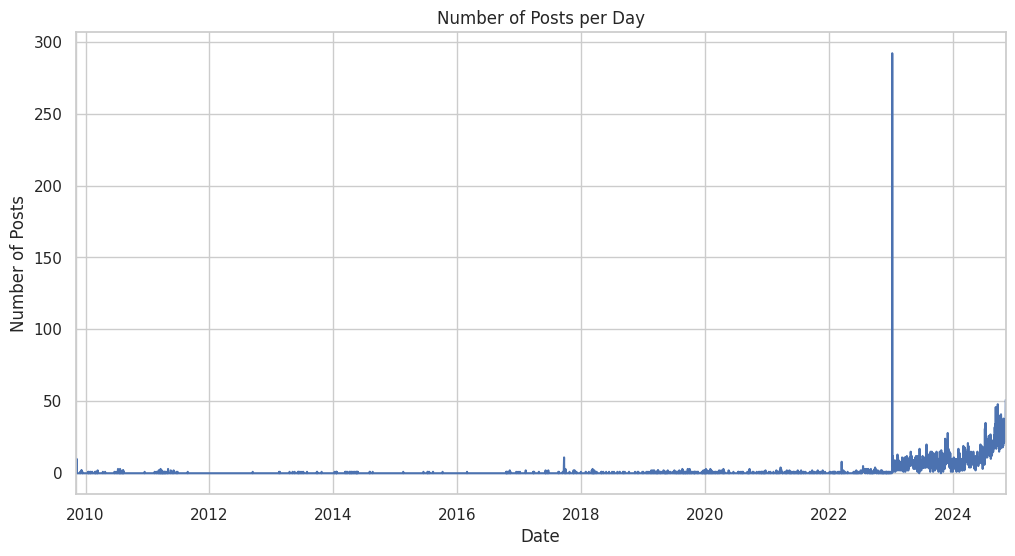

In [64]:
data['created_utc'] = pd.to_datetime(data['created_utc'])
data.set_index('created_utc', inplace=True)
daily_posts = data.resample('D').size()

plt.figure(figsize=FIGURE_SIZE)
daily_posts.plot()
plt.title('Number of Posts per Day')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

## 3. Language-specific Analysis

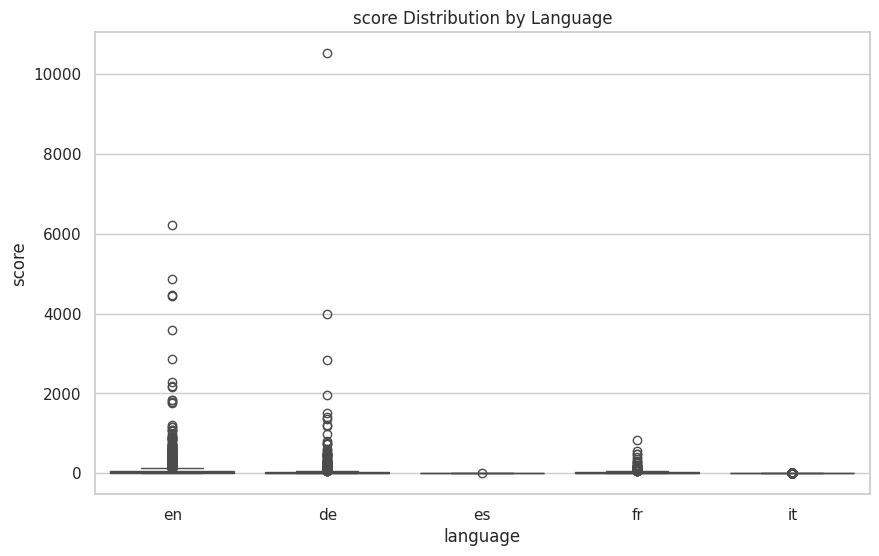

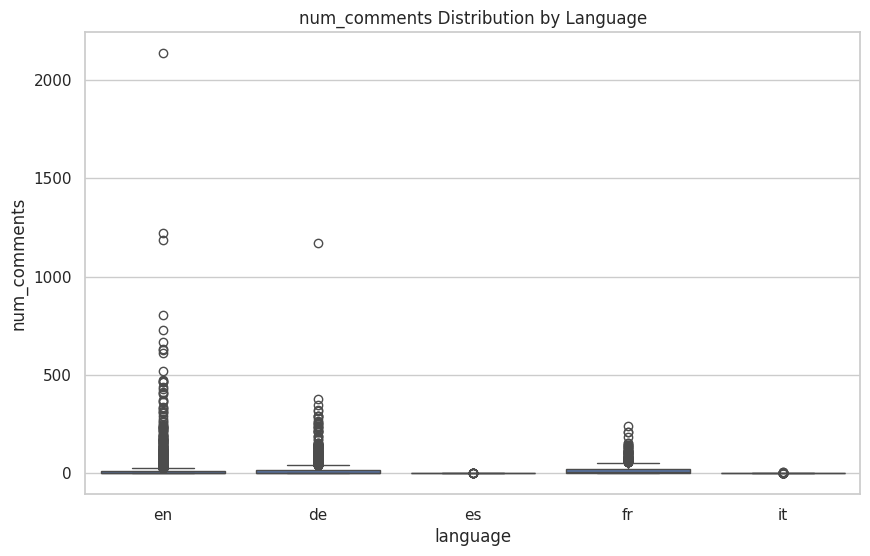

In [65]:
def plot_language_stats(data, column):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='language', y=column, data=data)
    plt.title(f'{column} Distribution by Language')
    plt.show()

plot_language_stats(data, 'score')
plot_language_stats(data, 'num_comments')

## 4. Content Analysis

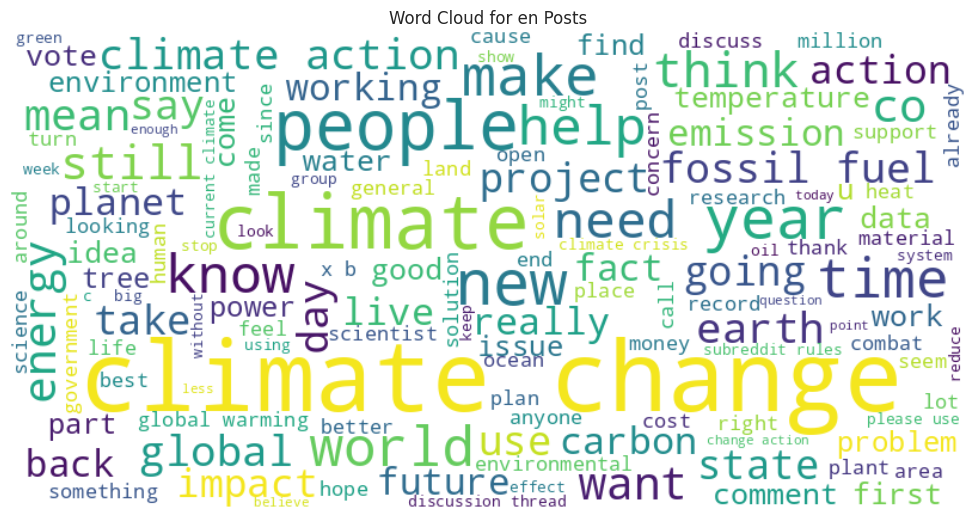

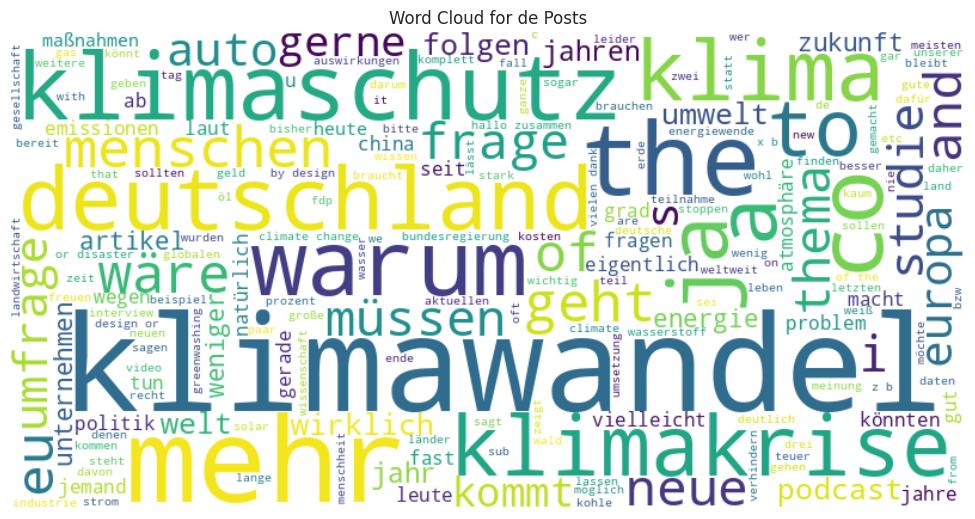

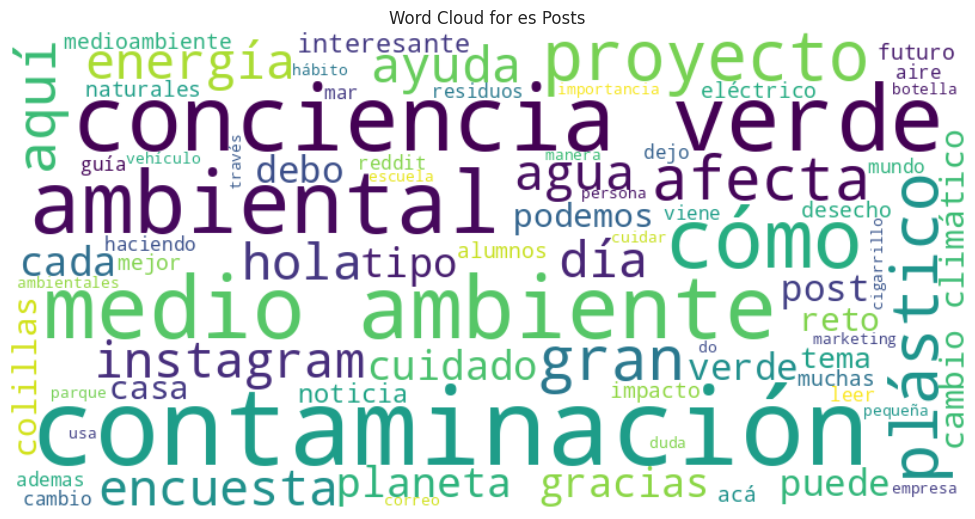

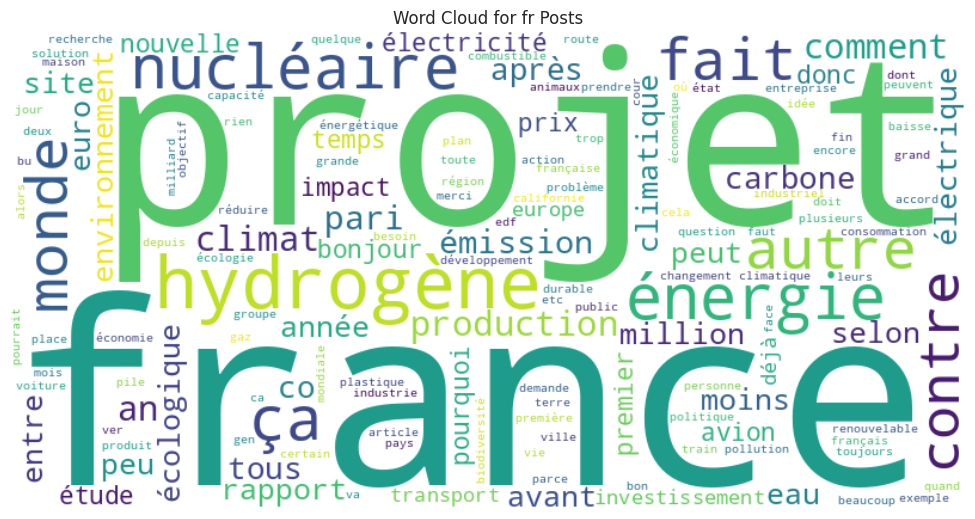

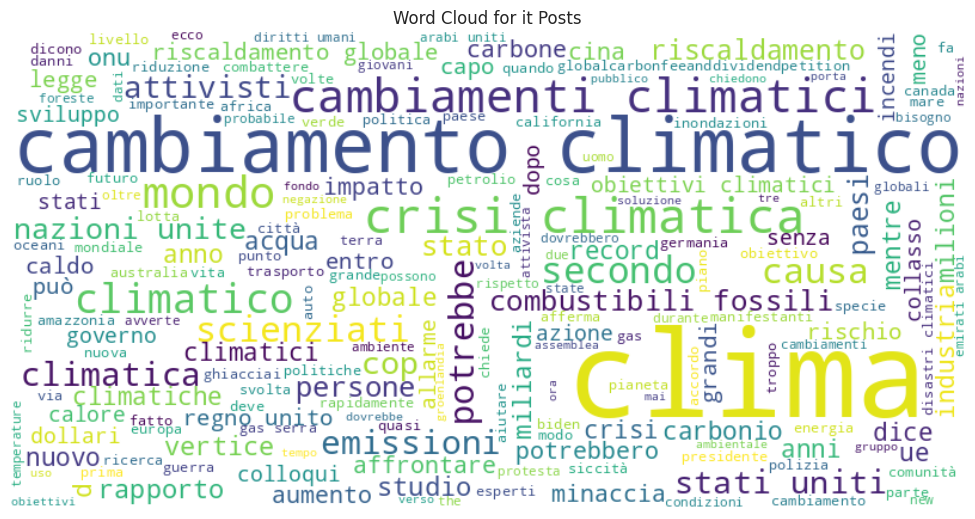

In [66]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re

# Download NLTK stop words data
nltk.download('stopwords', quiet=True)

def clean_text_func(text, language):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and digits
    text = re.sub(r'\W|\d', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def get_custom_stop_words(lang):
    custom_stop_words = {
        'english': {'like', 'just', 'get', 'go', 'would', 'could', 'should', 'us', 'one', 'also', 'may', 'well', 'even', 'much', 'many', 'see', 'way'},
        'german': {'mal', 'schon', 'einfach', 'ganz', 'viele', 'viel', 'immer', 'beim', 'gibt', 'sehr', 'kann', 'werden', 'wurde', 'dabei'},
        'spanish': {'si', 'como', 'que', 'esto', 'esta', 'hay', 'ser', 'estar', 'hacer', 'poder', 'más', 'muy', 'todo', 'también'},
        'french': {'cette', 'tout', 'comme', 'plus', 'être', 'faire', 'avoir', 'pouvoir', 'leur', 'même', 'aussi', 'bien', 'très', 'sans', 'a', 'ici', 'si'},
        'italian': {'che', 'come', 'anche', 'più', 'essere', 'fare', 'potere', 'dovere', 'molto', 'tutto', 'ancora', 'bene', 'proprio', 'solo'}
    }
    return custom_stop_words.get(lang, set())

def generate_wordcloud(text, title, language):
    # Get stop words for the specified language
    stop_words = set(stopwords.words(language))
    
    # Add custom stop words
    custom_stop_words = get_custom_stop_words(language)
    stop_words.update(custom_stop_words)
    
    # Create and generate a word cloud image
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         stopwords=stop_words, min_font_size=10).generate(text)
    
    # Display the generated image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.show()

# Map language codes to NLTK language names
language_map = {
    'en': 'english',
    'de': 'german',
    'es': 'spanish',
    'fr': 'french',
    'it': 'italian'
}

for lang in data['language'].unique():
    lang_data = data[data['language'] == lang]
    
    # Combine title and body, handle NaN values
    text = lang_data['title'].fillna('') + ' ' + lang_data['body'].fillna('')
    
    # Clean the text
    cleaned_text = ' '.join([clean_text_func(t, language_map.get(lang, 'english')) for t in text])
    
    # Generate word cloud
    generate_wordcloud(cleaned_text, f'Word Cloud for {lang} Posts', language_map.get(lang, 'english'))

## 5. Preliminary Stance Analysis

In [67]:
STANCE_DICT = {
    'en': {
        'positive': ['real', 'serious', 'urgent', 'important', 'necessary', 'crisis', 
                    'emergency', 'critical', 'significant', 'proven', 'evidence', 
                    'fact', 'scientific', 'agree', 'support', 'threat', 'danger', 
                    'catastrophic', 'devastating', 'crucial', 'essential'],
        'negative': ['hoax', 'fake', 'exaggerated', 'myth', 'scam', 'alarmist',
                    'alarmism', 'conspiracy', 'overblown', 'propaganda', 'lie',
                    'false', 'misleading', 'hysteria', 'hype', 'overreaction',
                    'agenda', 'political', 'fraud', 'deceptive'],
        'negators': ['not', 'never', 'no', "isn't", "aren't", "doesn't", "don't", 
                    'cannot', "can't", 'neither', 'nor', 'nothing', 'none',
                    'nowhere', 'nobody', 'rather', 'instead'],
        'diminishers': ['barely', 'hardly', 'scarcely', 'seldom', 'rarely', 
                       'slightly', 'somewhat', 'little', 'few', 'less', 'merely',
                       'just', 'only', 'limited'],
        'concern_indicators': [
            'sad', 'worried', 'concerned', 'afraid', 'fear', 'anxious',
            'destroyed', 'destruction', 'suffering', 'devastated', 'tragic',
            'terrible', 'horrific', 'awful', 'disaster', 'catastrophe'
        ],
        'environmental_harm': [
            'pollution', 'dumping', 'destroy', 'contamination', 'damage',
            'degradation', 'toxic', 'harm', 'devastation', 'extinction',
            'loss', 'death', 'dying', 'killed', 'ruined'
        ],
        'intensity_modifiers': [
            'incredibly', 'extremely', 'very', 'deeply', 'strongly',
            'completely', 'totally', 'absolutely', 'utterly', 'all but',
            'beyond', 'thoroughly'
        ],
        'future_indicators': ['will', 'going to', 'about to', 'shall'],
        'personal_indicators': ["i'm", "i am", "i feel", "i'm worried", "i can't", "i cannot"]
    },
    'de': {
        'positive': ['real', 'wirklich', 'ernst', 'dringend', 'wichtig', 'notwendig',
                    'krise', 'kritisch', 'wissenschaftlich', 'beweis', 'gefahr', 
                    'bedrohung', 'katastrophal', 'entscheidend', 'wesentlich', 'tatsache'],
        'negative': ['schwindel', 'falsch', 'übertrieben', 'mythos', 'betrug',
                    'propaganda', 'lüge', 'hysterie', 'irreführend', 'agenda',
                    'alarm', 'panik', 'täuschung', 'politik'],
        'negators': ['nicht', 'keine', 'kein', 'niemals', 'nie', 'nein', 'weder',
                    'noch', 'nichts', 'niemand', 'nirgends'],
        'diminishers': ['kaum', 'selten', 'wenig', 'gering', 'schwach', 'begrenzt',
                       'nur', 'bloß', 'lediglich'],
        'concern_indicators': [
            'traurig', 'besorgt', 'beunruhigt', 'ängstlich', 'angst', 'beängstigt',
            'zerstört', 'zerstörung', 'leidend', 'verwüstet', 'tragisch',
            'schrecklich', 'furchtbar', 'katastrophal', 'desaster'
        ],
        'environmental_harm': [
            'verschmutzung', 'müllentsorgung', 'zerstören', 'kontamination', 'schaden',
            'verschlechterung', 'giftig', 'schädlich', 'verwüstung', 'aussterben',
            'verlust', 'tod', 'sterbend', 'getötet', 'ruiniert'
        ],
        'intensity_modifiers': [
            'unglaublich', 'extrem', 'sehr', 'zutiefst', 'stark',
            'vollständig', 'total', 'absolut', 'völlig', 'geradezu',
            'durchaus', 'gänzlich'
        ],
        'future_indicators': ['wird', 'werden', 'soll', 'würde'],
        'personal_indicators': ['ich bin', 'ich fühle', 'ich kann nicht', 'mir ist']
    },
    'fr': {
        'positive': ['réel', 'sérieux', 'urgent', 'important', 'nécessaire', 'crise',
                    'critique', 'scientifique', 'preuve', 'danger', 'menace', 
                    'catastrophique', 'crucial', 'essentiel'],
        'negative': ['canular', 'faux', 'exagéré', 'mythe', 'arnaque', 'propagande',
                    'mensonge', 'hystérie', 'trompeur', 'agenda', 'politique',
                    'tromperie'],
        'negators': ['ne', 'pas', 'non', 'jamais', "n'est", "n'est pas", 'aucun',
                    'ni', 'personne', 'rien', 'nulle', "n'"],
        'diminishers': ['à peine', 'rarement', 'peu', 'guère', 'légèrement',
                       'simplement', 'seulement', 'uniquement'],
        'concern_indicators': [
            'triste', 'inquiet', 'préoccupé', 'effrayé', 'peur', 'anxieux',
            'détruit', 'destruction', 'souffrant', 'dévasté', 'tragique',
            'terrible', 'horrible', 'affreux', 'désastre', 'catastrophe'
        ],
        'environmental_harm': [
            'pollution', 'déversement', 'détruire', 'contamination', 'dommage',
            'dégradation', 'toxique', 'nuisible', 'dévastation', 'extinction',
            'perte', 'mort', 'mourant', 'tué', 'ruiné'
        ],
        'intensity_modifiers': [
            'incroyablement', 'extrêmement', 'très', 'profondément', 'fortement',
            'complètement', 'totalement', 'absolument', 'entièrement', 'tout à fait',
            'au-delà', 'parfaitement'
        ],
        'future_indicators': ['sera', 'seront', 'va', 'vont', 'aller'],
        'personal_indicators': ["je suis", "je me sens", "je ne peux pas", "je ressens"]
    },
    'es': {
        'positive': ['real', 'serio', 'urgente', 'importante', 'necesario', 'crisis',
                    'crítico', 'científico', 'evidencia', 'peligro', 'amenaza', 
                    'catastrófico', 'crucial', 'esencial'],
        'negative': ['engaño', 'falso', 'exagerado', 'mito', 'estafa', 'propaganda',
                    'mentira', 'histeria', 'engañoso', 'agenda', 'político',
                    'fraude'],
        'negators': ['no', 'nunca', 'ni', 'tampoco', 'jamas', 'ninguno', 'nada',
                    'nadie', 'ningun'],
        'diminishers': ['apenas', 'raramente', 'poco', 'escasamente', 'ligeramente',
                       'solamente', 'únicamente'],
        'concern_indicators': [
            'triste', 'preocupado', 'inquieto', 'asustado', 'miedo', 'ansioso',
            'destruido', 'destrucción', 'sufriendo', 'devastado', 'trágico',
            'terrible', 'horrible', 'awful', 'desastre', 'catástrofe'
        ],
        'environmental_harm': [
            'contaminación', 'vertido', 'destruir', 'contaminación', 'daño',
            'degradación', 'tóxico', 'perjudicial', 'devastación', 'extinción',
            'pérdida', 'muerte', 'muriendo', 'matado', 'arruinado'
        ],
        'intensity_modifiers': [
            'increíblemente', 'extremadamente', 'muy', 'profundamente', 'fuertemente',
            'completamente', 'totalmente', 'absolutamente', 'enteramente', 'casi',
            'más allá', 'thoroughmente'
        ],
        'future_indicators': ['será', 'serán', 'va a', 'van a', 'irá'],
        'personal_indicators': ["estoy", "me siento", "no puedo", "siento que"]
    },
    'it': {
        'positive': ['reale', 'serio', 'urgente', 'importante', 'necessario',
                    'crisi', 'critico', 'scientifico', 'evidenza', 'pericolo',
                    'minaccia', 'catastrofico', 'cruciale', 'essenziale'],
        'negative': ['bufala', 'falso', 'esagerato', 'mito', 'truffa', 'propaganda',
                    'bugia', 'isteria', 'ingannevole', 'agenda', 'politico',
                    'frode'],
        'negators': ['non', 'né', 'neanche', 'nemmeno', 'mai', 'niente', 'nessuno',
                    'nulla', 'mica'],
        'diminishers': ['appena', 'raramente', 'poco', 'scarso', 'leggermente',
                       'solamente', 'unicamente', 'semplicemente'],
        'concern_indicators': [
            'triste', 'preoccupato', 'inquieto', 'spaventato', 'paura', 'ansioso',
            'distrutto', 'distruzione', 'sofferente', 'devastato', 'tragico',
            'terribile', 'orribile', 'tremendo', 'disastro', 'catastrofe'
        ],
        'environmental_harm': [
            'inquinamento', 'scarico', 'distruggere', 'contaminazione', 'danno',
            'degradazione', 'tossico', 'nocivo', 'devastazione', 'estinzione',
            'perdita', 'morte', 'morente', 'ucciso', 'rovinato'
        ],
        'intensity_modifiers': [
            'incredibilmente', 'estremamente', 'molto', 'profondamente', 'fortemente',
            'completamente', 'totalmente', 'assolutamente', 'interamente', 'quasi',
            'oltre', 'completamente'
        ],
        'future_indicators': ['sarà', 'saranno', 'sta per', 'stanno per', 'andrà'],
        'personal_indicators': ["sono", "mi sento", "non posso", "sento che"]
    }
}

In [68]:
def assign_stance(text, language='en'):
    """
    Enhanced multilingual stance detector with improved pattern recognition.
    """
    text = text.lower()
    lang_dict = STANCE_DICT.get(language, STANCE_DICT['en'])
    
    pro_environmental_score = 0
    skepticism_score = 0
    
    # Process neither/nor constructions first
    words = text.split()
    
    # Handle "neither/nor" and equivalent constructions with higher weight
    neither_terms = {
        'en': ['neither', 'nor'],
        'de': ['weder', 'noch'],
        'fr': ['ni'],
        'es': ['ni'],
        'it': ['né', 'neanche']
    }
    
    if any(word in neither_terms.get(language, neither_terms['en']) for word in words):
        if any(word in lang_dict['negative'] for word in words):
            pro_environmental_score += 3  # Increased weight for neither/nor
    
    # Special handling for French negation patterns
    if language == 'fr':
        fr_negation_patterns = {
            "n'est pas": 2,
            "ne pas": 2,
            "pas de": 2,
            "pas une": 2,
            "pas un": 2
        }
        
        for pattern, score in fr_negation_patterns.items():
            if pattern in text:
                parts = text.split(pattern)
                if len(parts) > 1:
                    post_negation = parts[1].strip()
                    if any(neg in post_negation for neg in lang_dict['negative']):
                        pro_environmental_score += score + 1  # Increased weight
                    elif any(pos in post_negation for pos in lang_dict['positive']):
                        skepticism_score += score
    
    # Language-specific diminisher patterns
    language_patterns = {
        'en': [
            'hardly any', 'barely any', 'scarcely any', 'rarely any',
            'barely a', 'hardly a', 'scarcely a', 'slightly a'
        ],
        'fr': [
            'à peine une', 'à peine un', 'à peine de', 'à peine le',
            'légèrement une', 'légèrement un', 'légèrement le'
        ],
        'de': [
            'kaum eine', 'kaum ein', 'kaum der', 'kaum die',
            'selten eine', 'selten ein', 'selten der'
        ]
    }
    
    for pattern in language_patterns.get(language, []):
        if pattern in text:
            skepticism_score += 2
    
    # Process emotional concern and environmental harm
    concern_score = 0
    environmental_harm_score = 0
    
    for term in lang_dict['environmental_harm']:
        matches = len(re.findall(rf'\b{term}\w*\b', text))
        environmental_harm_score += matches * 1.5
    
    for term in lang_dict['concern_indicators']:
        matches = len(re.findall(rf'\b{term}\w*\b', text))
        concern_score += matches * 1.2
    
    # Handle regular negations
    i = 0
    while i < len(words):
        if words[i] in lang_dict['negators']:
            look_ahead = words[i+1:min(i+4, len(words))]
            # Handle negated skepticism ("not propaganda", "not a hoax")
            if any(word in lang_dict['negative'] for word in look_ahead):
                pro_environmental_score += 2.5  # Increased weight
                i += len(look_ahead)
                continue
            # Handle negated pro-environmental ("not real")
            elif any(word in lang_dict['positive'] for word in look_ahead):
                skepticism_score += 2
                i += len(look_ahead)
                continue
        i += 1
    
    # Process remaining terms
    for word in words:
        if word in lang_dict['positive']:
            pro_environmental_score += 1
        elif word in lang_dict['negative']:
            skepticism_score += 1
    
    # Add environmental and concern scores
    pro_environmental_score += environmental_harm_score + concern_score
    
    # Handle "rarely exaggerated" type patterns
    if any(dim in text for dim in lang_dict['diminishers']):
        if any(neg in text for neg in lang_dict['negative']):
            skepticism_score += 1.5
    
    # Final stance determination with adjusted thresholds
    score_difference = abs(pro_environmental_score - skepticism_score)
    
    # Lower threshold for pro-environmental when there's significant concern
    if environmental_harm_score + concern_score > 2:
        if pro_environmental_score > skepticism_score:
            return 'pro_environmental'
    
    if score_difference < 0.8 and (environmental_harm_score + concern_score < 2):
        return 'neutral'
    elif pro_environmental_score > skepticism_score:
        return 'pro_environmental'
    else:
        return 'skepticism'

In [69]:
# Test cases covering various scenarios
test_cases = {
    'en': [
        "Climate change is real and poses a serious threat",  # Multiple positives
        "Climate change is not real",  # Simple negation
        "Climate change is barely a serious issue",  # Diminished positive
        "This is not a fake crisis",  # Double negative
        "Climate change is slightly exaggerated but still real",  # Mixed with diminisher
        "Climate change is neither a hoax nor exaggerated",  # Multiple negatives with negators
        "There's hardly any evidence that climate change is real",  # Complex diminished
        "This is just alarmist propaganda",  # Multiple negatives with diminisher
        "The threat of climate change is rarely exaggerated",  # Complex mixed case
        "I'm incredibly sad for our environment today. Trump has all but signed a death warrant for our environment by securing a second term. I don't know how to feel or what to think. I know he had worked to undermine the EPA in his first term, but now with control of all branches of the government he will succeed. Illegal dumping will be commonplace. Our waterways will be destroyed. Pollution will go unfettered and we will all suffer. I'm sad for the wildlife who has no voice in the destruction of their home. I can't believe what a selfish, narcissistic country the US is."
    ],
    'de': [
        "Der Klimawandel ist eine echte wissenschaftliche Tatsache",  # Multiple positives
        "Der Klimawandel ist nicht real",  # Simple negation
        "Der Klimawandel ist kaum eine ernste Bedrohung",  # Diminished positive
        "Das ist keine Propaganda",  # Simple negative with negator
        "Der Klimawandel ist leicht übertrieben"  # Diminished negative
    ],
    'fr': [
        "Le changement climatique est une réelle menace",  # Multiple positives
        "Ce n'est pas une crise exagérée",  # Complex negation
        "Le changement climatique est à peine une menace",  # Diminished positive
        "Ce n'est pas de la propagande",  # Negated negative
        "Le changement climatique est légèrement exagéré"  # Diminished negative
    ]
}

# Run tests
for lang, texts in test_cases.items():
    print(f"\nTesting {lang.upper()} cases:")
    print("=" * 50)
    for text in texts:
        stance = assign_stance(text, lang)
        print(f"Text: {text}")
        print(f"Stance: {stance}")
        print("-" * 50)


Testing EN cases:
Text: Climate change is real and poses a serious threat
Stance: pro_environmental
--------------------------------------------------
Text: Climate change is not real
Stance: skepticism
--------------------------------------------------
Text: Climate change is barely a serious issue
Stance: skepticism
--------------------------------------------------
Text: This is not a fake crisis
Stance: pro_environmental
--------------------------------------------------
Text: Climate change is slightly exaggerated but still real
Stance: skepticism
--------------------------------------------------
Text: Climate change is neither a hoax nor exaggerated
Stance: pro_environmental
--------------------------------------------------
Text: There's hardly any evidence that climate change is real
Stance: skepticism
--------------------------------------------------
Text: This is just alarmist propaganda
Stance: skepticism
--------------------------------------------------
Text: The threat

In [70]:
def determine_stance(text, language='en'):
    """
    Multilingual wrapper for stance determination.
    
    Args:
        text (str): The text to analyze
        language (str): Language code of the text
    
    Returns:
        int: Stance code:
            +1: Pro-environmental/Climate concern
             0: Neutral
            -1: Climate skepticism/denial
    """
    if not text or len(str(text).strip()) < 50:
        return 0
        
    stance = assign_stance(text.lower(), language)
    
    stance_map = {
        'pro_environmental': 1,  # Pro-environmental gets +1
        'neutral': 0,           # Neutral stays at 0
        'skepticism': -1        # Skepticism gets -1
    }
    
    return stance_map[stance]

In [71]:
print("Determining stances for all posts...")
data['stance'] = data.apply(
    lambda row: determine_stance(
        f"{row['title']} {row['body']}", 
        row['language']
    ),
    axis=1
)
print(f"Finished processing {len(data)} posts")

Determining stances for all posts...


Finished processing 8081 posts


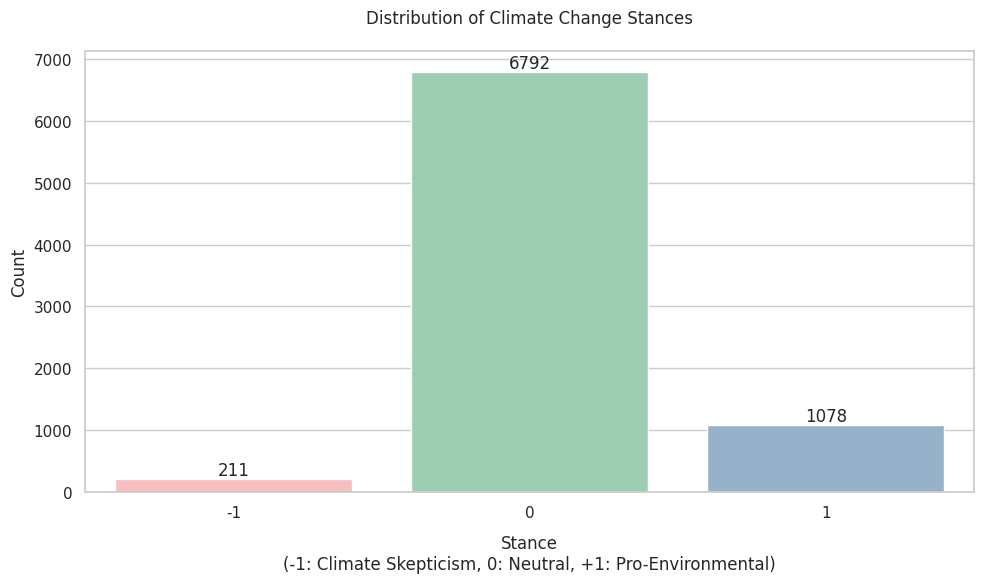

<Figure size 1200x600 with 0 Axes>

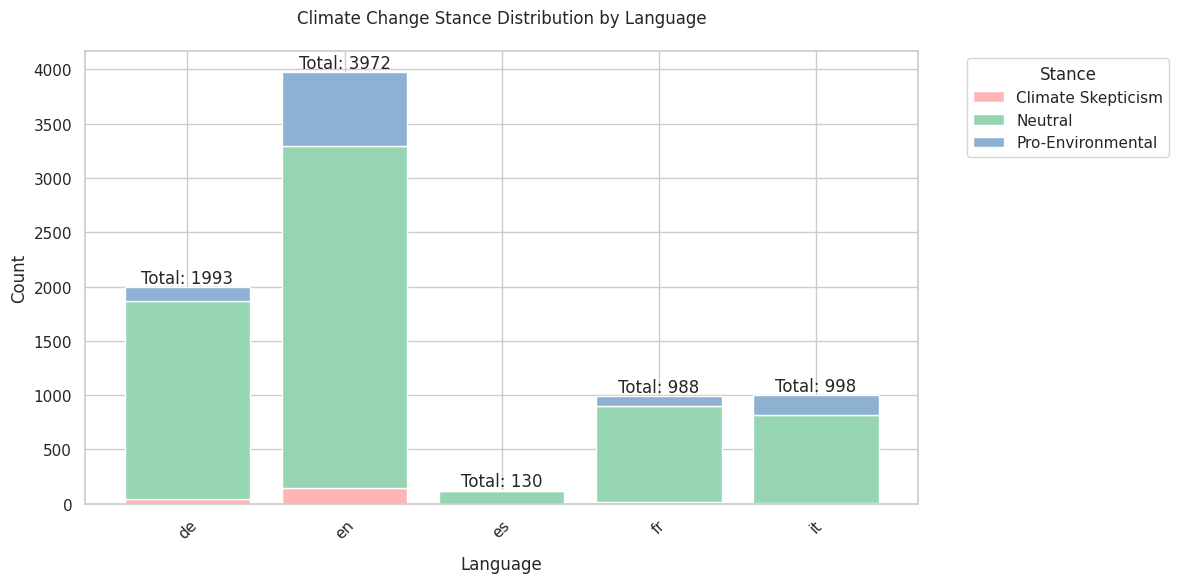

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set seaborn style with whitegrid
sns.set_style("whitegrid")
sns.set_palette("deep")

# Calculate stance distribution
stance_dist = data['stance'].value_counts().sort_index()  # Sort by index to ensure -1, 0, 1 order
colors = ['#FFB5B5', '#95D5B2', '#8DB1D3']

# First plot - Stance Distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=stance_dist.index,
    y=stance_dist.values,
    hue=stance_dist.index,  # Add hue to fix the warning
    palette=colors,
    legend=False  # Don't show legend since hue is just for colors
)

plt.title('Distribution of Climate Change Stances', pad=20, size=12)
plt.xlabel('Stance\n(-1: Climate Skepticism, 0: Neutral, +1: Pro-Environmental)', labelpad=10)
plt.ylabel('Count')

# Add value labels on top of each bar
for i, v in enumerate(stance_dist.values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()
plt.close()  # Close the figure to prevent the empty figure warning

# Second plot - Stance by Language
plt.figure(figsize=(12, 6))
stance_by_lang = pd.crosstab(data['language'], data['stance'])
stance_by_lang = stance_by_lang.reindex(columns=[-1, 0, 1])  # Ensure columns are in order

# Plot stacked bar chart
ax = stance_by_lang.plot(
    kind='bar', 
    stacked=True, 
    color=colors,
    width=0.8  # Slightly thinner bars for better visibility
)

plt.title('Climate Change Stance Distribution by Language', pad=20, size=12)
plt.xlabel('Language', labelpad=10)
plt.ylabel('Count')

plt.legend(
    title='Stance',
    labels=['Climate Skepticism', 'Neutral', 'Pro-Environmental'],
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Rotate x-labels for better readability
plt.xticks(rotation=45)

# Add totals on top of each bar
totals = stance_by_lang.sum(axis=1)
for i, total in enumerate(totals):
    plt.text(i, total, f'Total: {total}', ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()
plt.close()  # Close the figure

In [73]:
# Statistical testing for stance distribution
from scipy import stats

contingency_table = pd.crosstab(data['language'], data['stance'])
chi2_results = stats.chi2_contingency(contingency_table)
chi2_stat, p_value, dof, expected = chi2_results

print(f"Chi-square test results:")
print(f"Chi-square statistic: {chi2_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")

Chi-square test results:
Chi-square statistic: 214.5454
p-value: 0.0000
Degrees of freedom: 8


In [74]:
# Timestamp extraction
timestamp_str = latest_file.split('_')[-2] + '_' + latest_file.split('_')[-1].split('.')[0]
dt_obj = datetime.datetime.strptime(timestamp_str, '%Y%m%d_%H%M%S')

# Save the data with stance information
output_dir = '../data/processed/preprocessed_stance'
os.makedirs(output_dir, exist_ok=True)
output_path = f'{output_dir}/preprocessed_stance_{timestamp_str}.csv'
data.to_csv(output_path, index=False)
print(f"Saved preprocessed data to {output_path}")

# Save analysis results and take timestamp from raw data file
analysis_results = {
    'collection_timesstamp': dt_obj.strftime('%Y-%m-%d %H:%M:%S'),
    'total_posts': len(data),
    'language_distribution': data['language'].value_counts().to_dict(),
    'by_subreddit': data['subreddit'].value_counts().to_dict(),
    'stance_distribution': data['stance'].value_counts().to_dict(),
    'stance_by_language': stance_by_lang.to_dict(),
    'language_verification_rate': data['language_verified'].mean()*100,
    'chi2_test': {
        'chi2_statistic': chi2_stat,
        'p_value': p_value,
        'dof': dof
    },
    'mean_stats': {
        'title_length': data['title'].str.len().mean(),
        'body_length': data['body'].str.len().mean(),
        'score': data['score'].mean(),
        'comments': data['num_comments'].mean(),
    },
    'temporal_stats': {
        'earliest_post': data.index.min().strftime('%Y-%m-%d %H:%M:%S'),
        'latest_post': data.index.max().strftime('%Y-%m-%d %H:%M:%S'),
        'peak_day': daily_posts.idxmax().strftime('%Y-%m-%d'),
        'peak_posts': int(daily_posts.max())
    }
}

# Save as JSON with timestamp
import json
results_file = f'../data/processed/preprocessed_stats/preprocessed_stats_{timestamp_str}.json'
os.makedirs(os.path.dirname(results_file), exist_ok=True)
with open(results_file, 'w') as f:
    json.dump(analysis_results, f, indent=4)

Saved preprocessed data to ../data/processed/preprocessed_stance/preprocessed_stance_20241106_235507.csv


## 6. Conclusions and Initial Insights

Based on this exploratory analysis, we can draw some initial conclusions and outline next steps:

### 6.1. Data Quality
- Language verification rate: 97% (high confidence in language labels)
- Total samples processed: 8,081

### 6.2. Data Splits
- Training set: 5,657 samples (70%)
- Validation set: 808 samples (10%)
- Test set: 1,616 samples (20%)

### 6.3. Stance Distribution
- Neutral: 6,609 samples (81.8%)
- Positive: 1,377 samples (17.0%)
- Negative: 94 samples (1.2%)
  
### 6.4. Data Distribution and Language Representation:
   - English dominates the dataset with 3971 posts (49.1%)
   - German has strong representation with 1993 posts (24.7%)
   - Italian and French have similar representation (~990 posts each, ~12%)
   - Spanish is significantly underrepresented with only 130 posts (1.6%)

### 6.5. Content Analysis by Language:
   - English: Broad global perspective, focus on "climate change", action-oriented language
   - German: Strong national focus, emphasis on "Klimakrise" (climate crisis)
   - Spanish: Emphasis on environmental issues and water-related concerns
   - French: Dominated by energy discussions
   - Italian: Focus on "crisi climatica" and climate activism

### 6.6. Engagement Metrics:
   - High variability in post scores (mean ~38, median 10)
   - Comments show similar variability (mean ~14, median 2)
   - Some posts generated extensive discussion (max >1000 comments)

### 6.7. Key Challenges
   - Severe class imbalance in stance classification:
   - Neutral stance dominates the dataset
   - Very few negative stance samples
   - Need for imbalance handling strategies

### 6.8. Cross-Language Insights:
   - While climate change is a universal theme, each language community focuses on different aspects
   - National perspectives are strong in German and French discussions
   - Energy solutions are prominently discussed in French and German posts
   - Environmental pollution and water issues are uniquely emphasized in Spanish content
   - Italian discussions highlight the crisis aspect and climate activism
   - Spanish posts have the highest proportion of neutral stances

### 6.9. Emerging Trends:
   - The recent spike in posting activity coincides with more action-oriented discussions
   - Energy transitions are gaining traction, especially in French discourse
   - There's an increasing focus on local impacts of global climate change

### 6.10. Next Steps:
   - Consider collecting more Spanish content to balance the dataset
   - Refine stance detection algorithm with language-specific keywords
   - Develop more sophisticated content analysis methods
   - Implement cross-validation for stance detection
   - Create visualization dashboard for ongoing monitoring